In [1]:
import os
import numpy as np
from imutils import paths
import random
import math
import time


import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
#import torchvision.transforms
from torchvision import models, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

!pip -q install torchmetrics
from torchmetrics import Accuracy

device="cuda" if torch.cuda.is_available() else "cpu"

import tqdm as tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.6 MB/s eta 0:00:00


In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download hasyimabdillah/workoutexercises-images

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 817M/818M [00:43<00:00, 18.7MB/s]
100% 818M/818M [00:43<00:00, 19.6MB/s]


In [3]:
os.mkdir('/content/dataset')

In [4]:
from zipfile import ZipFile
zip = ZipFile('/content/workoutexercises-images.zip')
zip.extractall('/content/dataset')

In [5]:
from pathlib import Path, PurePath
import os
from sklearn.model_selection import train_test_split
from imutils import paths
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
import math
from torchvision import transforms
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import textwrap
from typing import List, Tuple
import torchvision
import pathlib
#import torchinfo
import math
import cv2

In [6]:
os.mkdir('/content/processed_data')

In [7]:
import shutil
from pathlib import Path


src_dir = Path('/content/dataset')
dst_dir = Path('/content/processed_data')


dst_dir.mkdir(exist_ok=True)
for subdir in src_dir.iterdir():
    if subdir.is_dir():
        (dst_dir / subdir.name).mkdir(exist_ok=True)
        for file in subdir.iterdir():
            if file.is_file():
                new_name = file.name.split('_', 1)[1]
                new_path = dst_dir / subdir.name / new_name
                shutil.copy(file, new_path)

In [8]:
count = 0
for root_dir, cur_dir, files in os.walk(r'/content/processed_data'):
    count += len(files)
print(count)

13853


**Image Hashing computation:**

In [9]:
import cv2
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

def dhash(image, hashSize=8):
	#grayscale - horizontal grad
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	resized = cv2.resize(gray, (hashSize + 1, hashSize))

	#horizontal grad
	diff = resized[:, 1:] > resized[:, :-1]

	# diff
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

# grab the paths to all images in our input dataset directory and
# then initialize our hashes dictionary

image_paths = list(paths.list_images('/content/processed_data'))
hashes = {}
for image_path in image_paths:
	# compute hash
	image = cv2.imread(image_path)
	h = dhash(image)

	# concat add
	p = hashes.get(h, [])
	p.append(image_path)
	hashes[h] = p

**Removing images with same hash values:**

In [10]:
args = {
	"dataset": "/content/processed_data",
	"remove": 1
}


for (h, hashed_paths) in hashes.items():
	if len(hashed_paths) > 1:
		if args["remove"] <= 0:
			# initialize a montage to store all images with the same hash
			montage = None
			for p in hashed_paths:
				# load the input image and resize it to a fixed width and heightG
				image = cv2.imread(p)
				image = cv2.resize(image, (150, 150))

				if montage is None:
					montage = image

				# otherwise, horizontally stack the images
				else:
					montage = np.hstack([montage, image])

			# show the montage for the hash
			print("[INFO] hash: {}".format(h))
			plt_imshow("Montage", montage)


		else:

			for p in hashed_paths[1:]:
				os.remove(p)

In [11]:
count = 0
for root_dir, cur_dir, files in os.walk(r'/content/processed_data'):
    count += len(files)
print(count)

13065


In [12]:
13853-count

788

**VAR:**

In [13]:
class config:

    # specify the paths to datasets
    DOWNLOAD_DIR = '/content/processed_data'
    TRAIN_DIR = 'data/train'
    VAL_DIR = 'data/val'
    TEST_DIR = 'data/test'

    # set the input height and width
    INPUT_HEIGHT = 224
    INPUT_WIDTH = 224

    # set the input height and width
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]

    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    #TRAINING_PARAMS = 'training_hyperparams/imagenet_regnetY_train_params'

**SPLIT:**

In [14]:
def split_image_folder(image_paths:str,
                folder:str):

  data_path = Path(folder)

  if not data_path.is_dir():
    data_path.mkdir(parents=True, exist_ok=True)

  for path in image_paths:
    full_path = Path(path)
    image_name = full_path.name
    label = full_path.parent.name
    label_folder = data_path / label

    if not label_folder.is_dir():
        label_folder.mkdir(parents=True, exist_ok=True)

    destination = label_folder / image_name
    shutil.copy(path, destination)

In [15]:
from sklearn.model_selection import train_test_split

# load all the image paths and split them into train & validation sets

image_paths = list(sorted(paths.list_images(config.DOWNLOAD_DIR)))

class_names = [Path(x).parent.name for x in image_paths]
train_paths, rest_of_paths = train_test_split(image_paths, stratify=class_names, test_size=0.15, shuffle=True, random_state=42)

class_names_ = [Path(x).parent.name for x in rest_of_paths]
val_paths, test_paths = train_test_split(rest_of_paths, stratify=class_names_, test_size=0.50, shuffle=True, random_state=42)


# copy the training and validation images to directories
split_image_folder(train_paths, config.TRAIN_DIR)
split_image_folder(val_paths, config.VAL_DIR)
split_image_folder(val_paths, config.TEST_DIR)

**VIZ:**

In [16]:
from PIL import Image, ImageDraw
from pathlib import PurePath

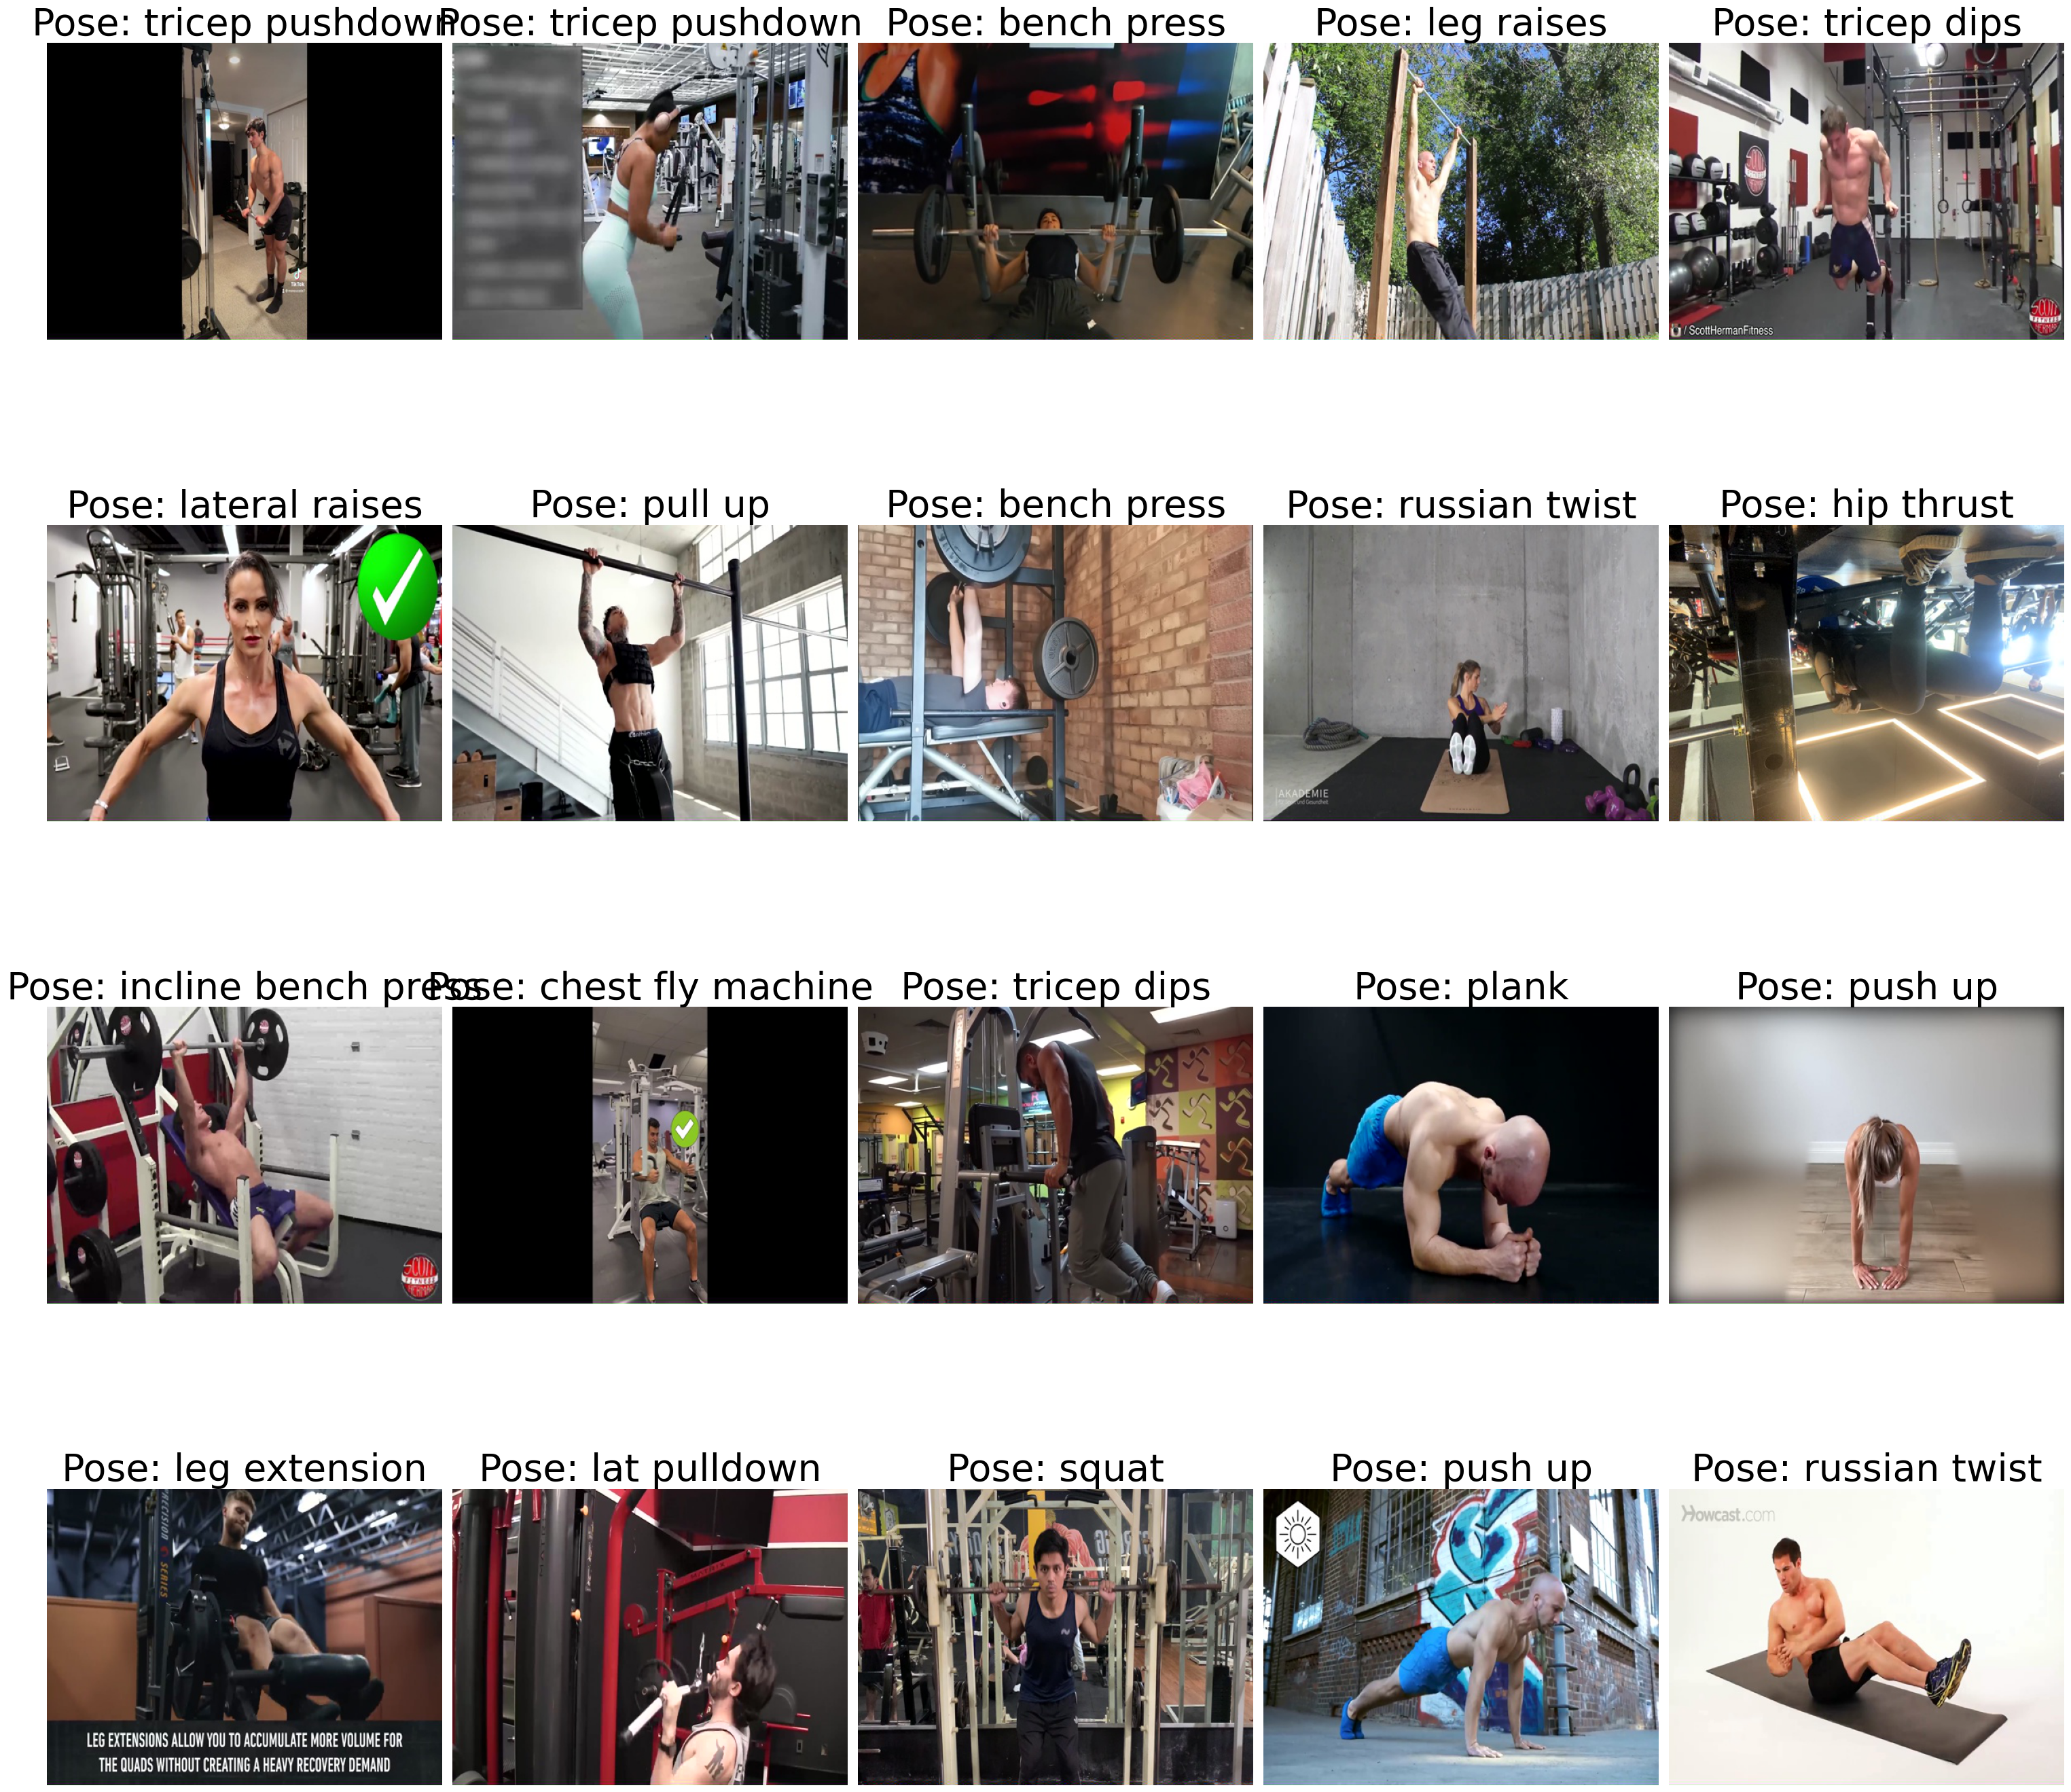

In [17]:
train_image_path_list = list(Path(config.TRAIN_DIR).glob("*/*.jpg"))
train_image_path_sample = random.sample(population=train_image_path_list, k=20)

def examine_images(images:list):
    num_images = len(images)
    num_rows = int(math.ceil(num_images/5))
    num_cols = 5

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 30),tight_layout=True)
    axs = axs.ravel()

    for i, image_path in enumerate(images[:num_images]):
        image = Image.open(image_path)
        label = PurePath(image_path).parent.name
        axs[i].imshow(image)
        axs[i].set_title(f"Pose: {label}", fontsize=40)
        axs[i].axis('off')
    plt.show()

examine_images(train_image_path_sample)

**Distribution of the images:**

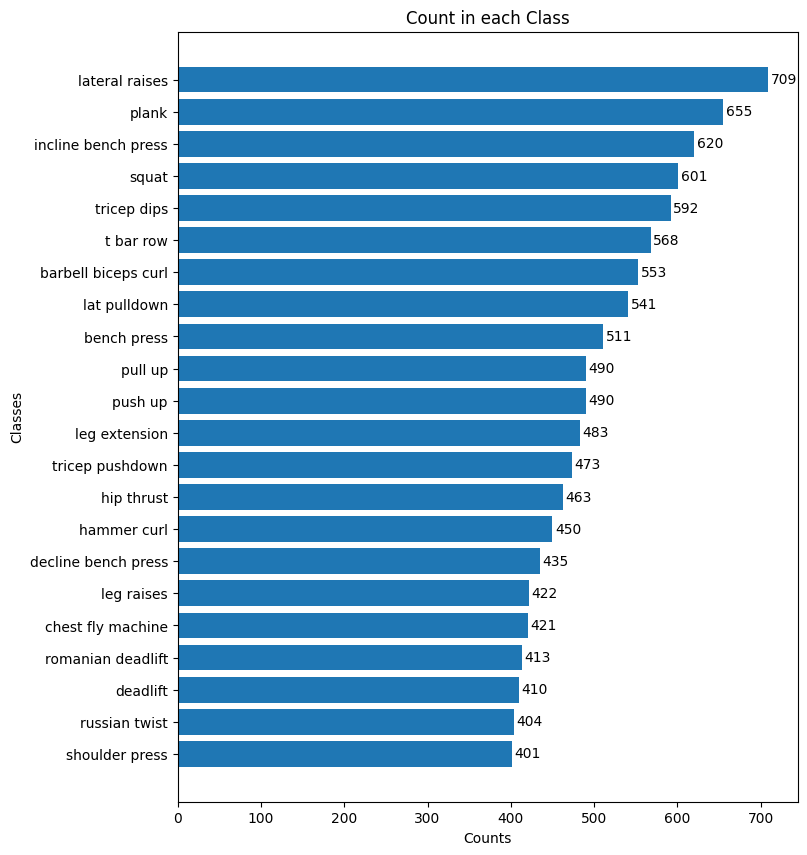

In [18]:
import matplotlib.pyplot as plt
from pathlib import Path

path = Path(config.TRAIN_DIR)


subdirs = [d for d in path.iterdir() if d.is_dir()]


image_count = {}


for subdir in subdirs:
    subdir_images = [img for img in subdir.glob("*.jpg")]
    image_count[subdir.name] = len(subdir_images)


sorted_subdirs = sorted(subdirs, key=lambda d: image_count[d.name])


plt.figure(figsize=(8, 10))
plt.barh(range(len(sorted_subdirs)), [image_count[d.name] for d in sorted_subdirs])
plt.yticks(range(len(sorted_subdirs)), [d.name for d in sorted_subdirs])


for i, count in enumerate([image_count[d.name] for d in sorted_subdirs]):
    plt.text(count + 3, i, str(count), va='center')


plt.title("Count in each Class")
plt.xlabel("Counts")
plt.ylabel("Classes")


plt.show()


In [37]:
#transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD)
#transforms.ColorJitter(brightness=(0.1,0.9), saturation=(0.5,0.9)),  #Changing Brightness and saturation
#transforms.RandomVerticalFlip(p=0.4),

data_transform={

    'train':transforms.Compose([ #Augmentation + Resize + Normalization

        #Most of these transforms are applied to simulate low res images and to counter the skin colour bias for implementation in the indian demographic as dataset is primarily
        #white, washed out and saturated.

        transforms.RandomResizedCrop(size=(224,224)), #224 X 224 imgs
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3)), #Blur
        transforms.RandomAdjustSharpness(sharpness_factor=2), #Sharpening
        transforms.ToTensor(),                      #ImageNet's mean and SD values
        transforms.Normalize([0.485, 0.456, 0.406], #mean across each RGB channel
                             [0.229, 0.224, 0.225]) #SD across each RGB channel
                                                    #in range of (0,1)
    ]),

    'val': transforms.Compose([ #Resize + Normalization

        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([ #Resize + Normalization

        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [38]:
Path="/content/data"
dataset={x: datasets.ImageFolder(os.path.join(Path, x),data_transform[x]) #splitting into train and val based on folder in dataset
          for x in ['train', 'val','test']
        }

dataloaders={x:torch.utils.data.DataLoader(dataset[x], batch_size=5,shuffle=True, num_workers=4) #defining dataloader for the model, number of dataset batches=5
              for x in ['train', 'val','test']
            }

dataset_Size={x:len(dataset[x]) for x in ['train','val','test']} #Determining size

label=dataset['train'].classes #fetching labels

device=torch.device("cuda:0") #prereq for passing data onto the gp

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**After Aug Viz:**

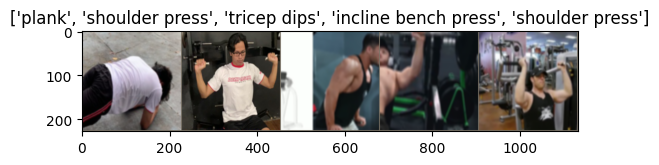

In [39]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[label[x] for x in classes])

**Viz Function for training:**

In [40]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {label[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [41]:
from tqdm import tqdm

In [42]:
import copy

In [52]:
def training(model, criterion, optimizer, scheduler, epoch_count=20):

    start=time.time() #keep track of initial starting time for calculating elapsed time

    weight_of_BestModel=copy.deepcopy(model.state_dict()) #Initialize variables to save weights and accuracy of the best model that runs through the epoches

    acc_of_BestModel=0.0

    for epoch in range(epoch_count):

        print(f'Epoch Number: {epoch}/{epoch_count-1}') #displaying current epoch
        print('_'*20)

        for phase in['train','val']: # 1 epoch = Training phase + Validation phase

            if phase=='train':
                model.train()  #training phase
            else:
                model.eval() #eval phase

            running_loss=0.0
            running_corrects=0

            for inputs, labels in tqdm(dataloaders[phase]):

                #passing dataset to GPU

                inputs=inputs.to(device)
                labels=labels.to(device)

                optimizer.zero_grad() #Zeroing gradients

                #enable gradients for forward pass

                with torch.set_grad_enabled(phase == 'train'):

                    outputs=model(inputs) #passing inputs to model
                    _, prediction=torch.max(outputs,1) #(max val of output, preds)
                    loss=criterion(outputs, labels) #cross entropy fn b/w predicted output and actual label-->loss function

                #Optimize for backward pass of Train

                    if phase == "train":
                        loss.backward() #calc gradients for backward pass
                        optimizer.step() #update parameters for each batch iteration

                #Claculating loss

                running_loss=running_loss+ loss.item()*inputs.size(0)
                running_corrects=running_corrects+torch.sum(prediction==labels.data)

            if phase=="train":
                scheduler.step() #change learning rate for each epoch-->lr deacy

            #Calc loss and acc for each epoch

            epoch_loss=running_loss/dataset_Size[phase]
            epoch_acc=running_corrects.double() / dataset_Size[phase]

            print(f'{phase} --> Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #Updating acc_of_BestModel and copying weights into weight_of_BestModel if current epoch accuracy is higher

            if phase=="val" and epoch_acc>acc_of_BestModel:
                acc_of_BestModel=epoch_acc
                weight_of_BestModel=copy.deepcopy(model.state_dict())

        print()

    elapsed_time=time.time()-start

    print(f'Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')
    #printing highest acc
    print(f'Best val Acc: {acc_of_BestModel:4f}')

    #loading weight_of_BestModel

    model.load_state_dict(weight_of_BestModel)
    return model


**Fixed Feature Extraction:**

In [53]:
rn50=torchvision.models.resnet50(pretrained=True) #loading pretrained model-resnet34

for param in rn50.parameters():

    param.requires_grad=False #freezing network params except for final layer where gradients are not calculated for backward pass

#Modifying the last fc layer

num_of_ftrs=rn50.fc.in_features # calculating number of inputs for the layers

rn50.fc=nn.Linear(num_of_ftrs, 22)

#passing to GPU
rn50=rn50.to(device)

#defining loss fn:

criterion=nn.CrossEntropyLoss()

optimizer_new=optim.SGD(rn50.fc.parameters(), lr=0.001, momentum=0.9) #optimizer for last fc layer only --> SGD

#LR decay by 0.1 factor for every 7 epoches

exp_lr_scheduler= lr_scheduler.StepLR(optimizer_new, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
ResNet_Model=training(rn50, criterion, optimizer_new, exp_lr_scheduler, epoch_count=20)

Epoch Number: 0/19
____________________


  0%|          | 0/2221 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 2221/2221 [02:33<00:00, 14.47it/s]


train --> Loss: 1.8964 Acc: 0.4580


100%|██████████| 196/196 [00:08<00:00, 23.18it/s]


val --> Loss: 1.0905 Acc: 0.6612

Epoch Number: 1/19
____________________


100%|██████████| 2221/2221 [02:35<00:00, 14.32it/s]


train --> Loss: 1.3077 Acc: 0.6167


100%|██████████| 196/196 [00:07<00:00, 26.82it/s]


val --> Loss: 0.7255 Acc: 0.7520

Epoch Number: 2/19
____________________


100%|██████████| 2221/2221 [02:32<00:00, 14.61it/s]


train --> Loss: 1.1501 Acc: 0.6647


100%|██████████| 196/196 [00:08<00:00, 23.47it/s]


val --> Loss: 0.6102 Acc: 0.8255

Epoch Number: 3/19
____________________


100%|██████████| 2221/2221 [02:30<00:00, 14.80it/s]


train --> Loss: 1.0831 Acc: 0.6778


100%|██████████| 196/196 [00:07<00:00, 27.92it/s]


val --> Loss: 0.5293 Acc: 0.8357

Epoch Number: 4/19
____________________


100%|██████████| 2221/2221 [02:30<00:00, 14.75it/s]


train --> Loss: 1.0351 Acc: 0.6966


100%|██████████| 196/196 [00:08<00:00, 23.75it/s]


val --> Loss: 0.5204 Acc: 0.8490

Epoch Number: 5/19
____________________


100%|██████████| 2221/2221 [02:28<00:00, 14.96it/s]


train --> Loss: 1.0052 Acc: 0.7016


100%|██████████| 196/196 [00:06<00:00, 28.39it/s]


val --> Loss: 0.5514 Acc: 0.8316

Epoch Number: 6/19
____________________


100%|██████████| 2221/2221 [02:31<00:00, 14.69it/s]


train --> Loss: 0.9682 Acc: 0.7115


100%|██████████| 196/196 [00:08<00:00, 23.65it/s]


val --> Loss: 0.4857 Acc: 0.8469

Epoch Number: 7/19
____________________


100%|██████████| 2221/2221 [02:32<00:00, 14.60it/s]


train --> Loss: 0.8346 Acc: 0.7555


100%|██████████| 196/196 [00:08<00:00, 24.02it/s]


val --> Loss: 0.4921 Acc: 0.8561

Epoch Number: 8/19
____________________


100%|██████████| 2221/2221 [02:37<00:00, 14.09it/s]


train --> Loss: 0.8355 Acc: 0.7623


100%|██████████| 196/196 [00:07<00:00, 24.56it/s]


val --> Loss: 0.4563 Acc: 0.8622

Epoch Number: 9/19
____________________


100%|██████████| 2221/2221 [02:35<00:00, 14.25it/s]


train --> Loss: 0.8603 Acc: 0.7475


100%|██████████| 196/196 [00:06<00:00, 28.21it/s]


val --> Loss: 0.4085 Acc: 0.8908

Epoch Number: 10/19
____________________


100%|██████████| 2221/2221 [02:33<00:00, 14.42it/s]


train --> Loss: 0.8467 Acc: 0.7511


100%|██████████| 196/196 [00:08<00:00, 23.40it/s]


val --> Loss: 0.4469 Acc: 0.8643

Epoch Number: 11/19
____________________


100%|██████████| 2221/2221 [02:35<00:00, 14.27it/s]


train --> Loss: 0.8279 Acc: 0.7597


100%|██████████| 196/196 [00:08<00:00, 23.16it/s]


val --> Loss: 0.4591 Acc: 0.8745

Epoch Number: 12/19
____________________


100%|██████████| 2221/2221 [02:33<00:00, 14.50it/s]


train --> Loss: 0.8394 Acc: 0.7572


100%|██████████| 196/196 [00:06<00:00, 28.36it/s]


val --> Loss: 0.4466 Acc: 0.8714

Epoch Number: 13/19
____________________


100%|██████████| 2221/2221 [02:33<00:00, 14.43it/s]


train --> Loss: 0.8330 Acc: 0.7553


100%|██████████| 196/196 [00:08<00:00, 23.92it/s]


val --> Loss: 0.4907 Acc: 0.8602

Epoch Number: 14/19
____________________


100%|██████████| 2221/2221 [02:30<00:00, 14.75it/s]


train --> Loss: 0.8278 Acc: 0.7579


100%|██████████| 196/196 [00:06<00:00, 28.63it/s]


val --> Loss: 0.4188 Acc: 0.8724

Epoch Number: 15/19
____________________


100%|██████████| 2221/2221 [02:29<00:00, 14.85it/s]


train --> Loss: 0.8371 Acc: 0.7548


100%|██████████| 196/196 [00:08<00:00, 23.73it/s]


val --> Loss: 0.4177 Acc: 0.8745

Epoch Number: 16/19
____________________


100%|██████████| 2221/2221 [02:34<00:00, 14.34it/s]


train --> Loss: 0.8524 Acc: 0.7507


100%|██████████| 196/196 [00:09<00:00, 21.14it/s]


val --> Loss: 0.4060 Acc: 0.8867

Epoch Number: 17/19
____________________


100%|██████████| 2221/2221 [02:41<00:00, 13.79it/s]


train --> Loss: 0.8436 Acc: 0.7539


100%|██████████| 196/196 [00:08<00:00, 23.14it/s]


val --> Loss: 0.4264 Acc: 0.8776

Epoch Number: 18/19
____________________


100%|██████████| 2221/2221 [02:34<00:00, 14.36it/s]


train --> Loss: 0.8224 Acc: 0.7593


100%|██████████| 196/196 [00:08<00:00, 23.32it/s]


val --> Loss: 0.4666 Acc: 0.8571

Epoch Number: 19/19
____________________


100%|██████████| 2221/2221 [02:31<00:00, 14.63it/s]


train --> Loss: 0.8225 Acc: 0.7571


100%|██████████| 196/196 [00:06<00:00, 28.02it/s]

val --> Loss: 0.4850 Acc: 0.8551

Training complete in 53m 44s
Best val Acc: 0.890816


**Save model:**

In [55]:
torch.save(ResNet_Model,'model.pth')
torch.save(ResNet_Model.state_dict(),'model_weights.pth')

In [ ]:
rem=["hip thrust, lat pulldown, chest fly machine,leg extension, romanian deadlift, russian twist, plank, tricep dips, t bar row,decline benchpress, incline benchpress, leg rises"]

In [ ]:
from sklearn.metrics import confusion_matrix


best_full_model.eval()


true_labels = []
predicted_labels = []

for images, labels in test_dataloader:
    images = images.to(config.DEVICE)
    labels = labels.to(config.DEVICE)
    with torch.no_grad():
        outputs = best_full_model(images)
        _, predicted = torch.max(outputs.data, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(true_labels, predicted_labels)


fig, ax = plt.subplots(figsize=(12, 10))
plt.rcParams.update({'font.size': 16})


im = ax.imshow(conf_matrix, cmap='Blues')


cbar = ax.figure.colorbar(im, ax=ax)


ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=14)
ax.set_yticklabels(class_names, fontsize=14)
ax.set_xlabel('Predicted label', fontsize=16)
ax.set_ylabel('True label', fontsize=16)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


for i in range(len(class_names)):
    for j in range(len(class_names)):
        if conf_matrix[i, j] >= -1:
            text = ax.text(j, i, conf_matrix[i, j],
                           ha="center", va="center", color="y", fontsize=16)
        else:
            text = ax.text(j, i, "",
                           ha="center", va="center", color="y")


ax.set_title("Confusion matrix", fontsize=20)

plt.show()